# Blend cross-over

## run 1

In [7]:
import random
from PIL import Image, ImageDraw
import numpy as np
from skimage.metrics import structural_similarity as ssim
from copy import deepcopy
from sklearn.cluster import KMeans
import cv2

class Color:
    def __init__(self, filename, num_colors=10):
        self.target_image = cv2.imread(filename)
        self.target_image = cv2.cvtColor(self.target_image, cv2.COLOR_BGR2RGB)
        self.height, self.width, _ = self.target_image.shape
        self.palette = self.extract_palette(self.target_image, num_colors).astype(int)
        print("Extracted palette:", self.palette)

    def extract_palette(self, image, num_colors=10):
        pixels = image.reshape((-1, 3))
        kmeans = KMeans(n_clusters=num_colors)
        kmeans.fit(pixels)
        palette = kmeans.cluster_centers_
        return palette

class Triangle:
    def __init__(self, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.palette = palette
        x = random.randint(0, img_width)
        y = random.randint(0, img_height)

        self.points = [
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50))
        ]
        self.color = tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int))

    def mutate(self, mutation_rate=0.01):
        if random.random() < mutation_rate:
            mutation_type = random.choice(['shift', 'point', 'color', 'swap'])
            if mutation_type == 'shift':
                self.points = [(x + random.randint(-50, 50), y + random.randint(-50, 50)) for x, y in self.points]
            elif mutation_type == 'point':
                index = random.choice(range(3))
                self.points[index] = (self.points[index][0] + random.randint(-50, 50), self.points[index][1] + random.randint(-50, 50))
            elif mutation_type == 'color':
                self.color = tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int))
            elif mutation_type == 'swap':
                i, j = random.sample(range(3), 2)
                self.points[i], self.points[j] = self.points[j], self.points[i]

class Painting:
    def __init__(self, num_triangles, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.triangles = [Triangle(img_width, img_height, palette) for _ in range(num_triangles)]

    def draw(self) -> Image:
        image = Image.new("RGBA", (self._img_width, self._img_height), (255, 255, 255, 255))
        draw = ImageDraw.Draw(image)
        for t in self.triangles:
            draw.polygon(t.points, fill=t.color)
        return image

    def mutate(self, mutation_rate=0.01):
        for triangle in self.triangles:
            triangle.mutate(mutation_rate)

def calculate_fitness(painting, target_image):
    target_array = np.array(target_image.convert('L'))
    rendered_image = np.array(painting.draw().convert('L'))
    ssim_value = ssim(target_array, rendered_image)
    return 1 - ssim_value

def blend_crossover(parent1, parent2):
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)

    for i in range(len(parent1.triangles)):
        for j in range(3):
            alpha = random.uniform(-0.5, 1.5)
            child1.triangles[i].points[j] = (
                int((1 - alpha) * parent1.triangles[i].points[j][0] + alpha * parent2.triangles[i].points[j][0]),
                int((1 - alpha) * parent1.triangles[i].points[j][1] + alpha * parent2.triangles[i].points[j][1])
            )

    return child1, child2

class Population:
    def __init__(self, size, img_width, img_height, num_triangles, target_image, palette):
        self.size = size
        self.img_width = img_width
        self.img_height = img_height
        self.num_triangles = num_triangles
        self.target_image = target_image
        self.palette = palette
        self.individuals = [Painting(num_triangles, img_width, img_height, palette) for _ in range(size)]
        self.fitness = [calculate_fitness(ind, target_image) for ind in self.individuals]
        self.fitness_history = []

    def evolve(self, gens, xo_prob, mut_prob, elitism):
        for gen in range(gens):
            new_pop = []
            if elitism:
                elite = deepcopy(self.individuals[self.fitness.index(min(self.fitness))])

            while len(new_pop) < self.size:
                parent1 = self.tournament_selection()
                parent2 = self.tournament_selection()

                if random.random() < xo_prob:
                    child1, child2 = blend_crossover(parent1, parent2)
                else:
                    child1, child2 = deepcopy(parent1), deepcopy(parent2)

                child1.mutate(mut_prob)
                child2.mutate(mut_prob)

                new_pop.extend([child1, child2])

            if elitism:
                worst_index = self.fitness.index(max(self.fitness))
                new_pop[worst_index] = elite

            self.individuals = new_pop[:self.size]
            self.fitness = [calculate_fitness(ind, self.target_image) for ind in self.individuals]
            self.fitness_history.append(min(self.fitness))

            print(f"Generation {gen + 1}, Best Fitness: {min(self.fitness)}")

    def tournament_selection(self, k=3):
        selected = random.sample(list(zip(self.individuals, self.fitness)), k)
        return min(selected, key=lambda x: x[1])[0]

# Parameters
population_size = 50
num_triangles = 100
generations = 500
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

# File to save fitness values
fitness_file = "fitness_values_.txt"

for run in range(1):
    print(f"Run {run + 1}")
    
    # Load target image
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    # Extract palette from target image
    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    # Initialize and evolve population
    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    # Append fitness history for this run to the file
    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 1


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [ 85  85  85]
 [119  66   0]
 [181 181 181]
 [ 41  36  31]
 [135 135 135]
 [222 222 222]
 [223 123   0]]
Generation 1, Best Fitness: 0.33004245527448417
Generation 2, Best Fitness: 0.3296741731302095
Generation 3, Best Fitness: 0.32904251072851876
Generation 4, Best Fitness: 0.32815795148623905
Generation 5, Best Fitness: 0.32798196527025325
Generation 6, Best Fitness: 0.3273324043918072
Generation 7, Best Fitness: 0.3273324043918072
Generation 8, Best Fitness: 0.3256407009131582
Generation 9, Best Fitness: 0.3256407009131582
Generation 10, Best Fitness: 0.32487806533781327
Generation 11, Best Fitness: 0.3241116695345152
Generation 12, Best Fitness: 0.3241116695345152
Generation 13, Best Fitness: 0.323731490255478
Generation 14, Best Fitness: 0.3227582851360401
Generation 15, Best Fitness: 0.322490859294008
Generation 16, Best Fitness: 0.3216453028671873
Generation 17, Best Fitness: 0.321412410183021
Generation 18, Best F

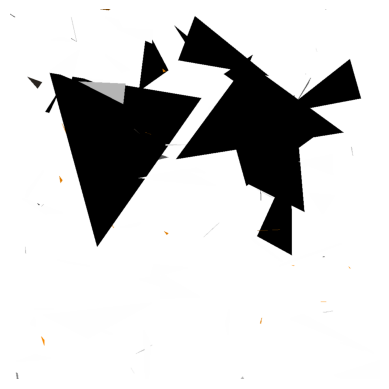

In [8]:
import matplotlib.pyplot as plt

# Get the best individual
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

# Convert the best individual to an image
best_image = best_individual.draw()

# Convert the image to a format suitable for plt.imshow
best_image_array = np.array(best_image)

# Display the image using Matplotlib
plt.imshow(best_image_array)
plt.axis('off')  # Turn off axis labels
plt.show()

# run 2

In [9]:

# Parameters
population_size = 50
num_triangles = 100
generations = 500
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

# File to save fitness values
fitness_file = "fitness_values_.txt"

for run in range(1):
    print(f"Run {run + 1}")
    
    # Load target image
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    # Extract palette from target image
    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    # Initialize and evolve population
    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    # Append fitness history for this run to the file
    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 1


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [ 86  86  86]
 [182 182 182]
 [119  66   0]
 [ 41  36  31]
 [222 222 222]
 [223 123   0]
 [136 136 136]]
Generation 1, Best Fitness: 0.32477387564536253
Generation 2, Best Fitness: 0.3246797967686842
Generation 3, Best Fitness: 0.3245133459689534
Generation 4, Best Fitness: 0.32412571085862374
Generation 5, Best Fitness: 0.3237309244535175
Generation 6, Best Fitness: 0.3232192807344242
Generation 7, Best Fitness: 0.32308681933337
Generation 8, Best Fitness: 0.32246462059750103
Generation 9, Best Fitness: 0.32217831802209873
Generation 10, Best Fitness: 0.3216082148103895
Generation 11, Best Fitness: 0.3208437600409241
Generation 12, Best Fitness: 0.3202685446716541
Generation 13, Best Fitness: 0.31958912130345596
Generation 14, Best Fitness: 0.31958912130345596
Generation 15, Best Fitness: 0.31958912130345596
Generation 16, Best Fitness: 0.31951489826931445
Generation 17, Best Fitness: 0.3192589933717007
Generation 18, Be

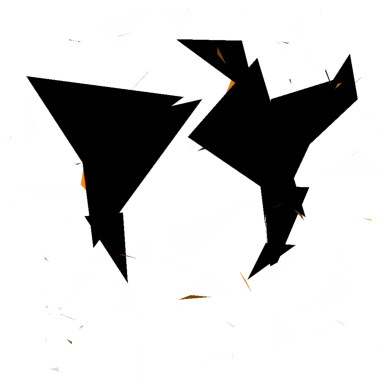

In [10]:
import matplotlib.pyplot as plt

# Get the best individual
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

# Convert the best individual to an image
best_image = best_individual.draw()

# Convert the image to a format suitable for plt.imshow
best_image_array = np.array(best_image)

# Display the image using Matplotlib
plt.imshow(best_image_array)
plt.axis('off')  # Turn off axis labels
plt.show()

# run 3

In [11]:

# Parameters
population_size = 50
num_triangles = 100
generations = 500
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

# File to save fitness values
fitness_file = "fitness_values_.txt"

for run in range(1):
    print(f"Run {run + 1}")
    
    # Load target image
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    # Extract palette from target image
    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    # Initialize and evolve population
    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    # Append fitness history for this run to the file
    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 1


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [ 71  71  71]
 [159 159 159]
 [119  66   0]
 [210 210 210]
 [223 123   0]
 [113 113 113]
 [ 36  30  24]]
Generation 1, Best Fitness: 0.3293748440982168
Generation 2, Best Fitness: 0.3293017611329585
Generation 3, Best Fitness: 0.3282648418734272
Generation 4, Best Fitness: 0.3282648418734272
Generation 5, Best Fitness: 0.32814186757152186
Generation 6, Best Fitness: 0.3269025149476674
Generation 7, Best Fitness: 0.3262797429151738
Generation 8, Best Fitness: 0.3257673734364006
Generation 9, Best Fitness: 0.3239813350624663
Generation 10, Best Fitness: 0.3239813350624663
Generation 11, Best Fitness: 0.3234899893048051
Generation 12, Best Fitness: 0.3234083435017914
Generation 13, Best Fitness: 0.32239272764260163
Generation 14, Best Fitness: 0.3219594191085585
Generation 15, Best Fitness: 0.32050678853436243
Generation 16, Best Fitness: 0.32050678853436243
Generation 17, Best Fitness: 0.319103869917696
Generation 18, Best 

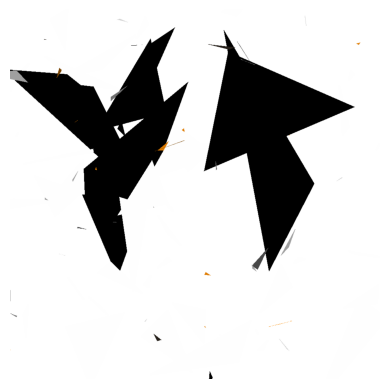

In [12]:
import matplotlib.pyplot as plt

# Get the best individual
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

# Convert the best individual to an image
best_image = best_individual.draw()

# Convert the image to a format suitable for plt.imshow
best_image_array = np.array(best_image)

# Display the image using Matplotlib
plt.imshow(best_image_array)
plt.axis('off')  # Turn off axis labels
plt.show()

# run 4

In [13]:
# Parameters
population_size = 50
num_triangles = 100
generations = 500
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

# File to save fitness values
fitness_file = "fitness_values_.txt"

for run in range(1):
    print(f"Run {run + 1}")
    
    # Load target image
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    # Extract palette from target image
    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    # Initialize and evolve population
    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    # Append fitness history for this run to the file
    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 1


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [ 85  85  85]
 [182 182 182]
 [119  66   0]
 [135 135 135]
 [ 41  36  30]
 [223 223 223]
 [223 123   0]]
Generation 1, Best Fitness: 0.32617763823496193
Generation 2, Best Fitness: 0.32617763823496193
Generation 3, Best Fitness: 0.32617763823496193
Generation 4, Best Fitness: 0.3261353808597942
Generation 5, Best Fitness: 0.3247962445173328
Generation 6, Best Fitness: 0.32470056365557665
Generation 7, Best Fitness: 0.32438830365492366
Generation 8, Best Fitness: 0.3223079361340563
Generation 9, Best Fitness: 0.3223079361340563
Generation 10, Best Fitness: 0.32168189369948474
Generation 11, Best Fitness: 0.3214445535950917
Generation 12, Best Fitness: 0.3212689423262167
Generation 13, Best Fitness: 0.32107043374819844
Generation 14, Best Fitness: 0.3198644955190202
Generation 15, Best Fitness: 0.31808040873866616
Generation 16, Best Fitness: 0.31789080897052235
Generation 17, Best Fitness: 0.31721810415188145
Generation 18

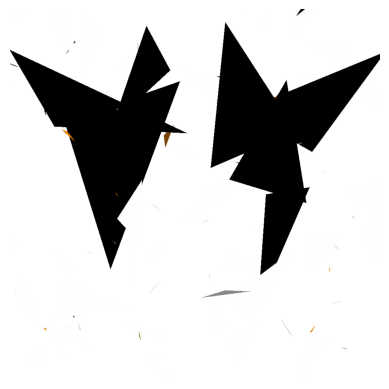

In [14]:
import matplotlib.pyplot as plt

# Get the best individual
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

# Convert the best individual to an image
best_image = best_individual.draw()

# Convert the image to a format suitable for plt.imshow
best_image_array = np.array(best_image)

# Display the image using Matplotlib
plt.imshow(best_image_array)
plt.axis('off')  # Turn off axis labels
plt.show()

# run 5

In [15]:
# Parameters
population_size = 50
num_triangles = 100
generations = 500
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

# File to save fitness values
fitness_file = "fitness_values_.txt"

for run in range(1):
    print(f"Run {run + 1}")
    
    # Load target image
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    # Extract palette from target image
    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    # Initialize and evolve population
    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    # Append fitness history for this run to the file
    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 1


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [109 109 109]
 [123  68   0]
 [187 187 187]
 [ 37  31  24]
 [ 71  71  71]
 [224 224 224]
 [147 147 147]]
Generation 1, Best Fitness: 0.3292093576739029
Generation 2, Best Fitness: 0.3292093576739029
Generation 3, Best Fitness: 0.3291463810110139
Generation 4, Best Fitness: 0.32828028246313334
Generation 5, Best Fitness: 0.3275163589753217
Generation 6, Best Fitness: 0.32744114084687226
Generation 7, Best Fitness: 0.3270814004803667
Generation 8, Best Fitness: 0.32650828595611303
Generation 9, Best Fitness: 0.3249426756776821
Generation 10, Best Fitness: 0.3244591686996461
Generation 11, Best Fitness: 0.3240167656720525
Generation 12, Best Fitness: 0.3226927167070376
Generation 13, Best Fitness: 0.3218043060694328
Generation 14, Best Fitness: 0.3205727708940903
Generation 15, Best Fitness: 0.3203721057015826
Generation 16, Best Fitness: 0.31995933429066215
Generation 17, Best Fitness: 0.318766306508217
Generation 18, Best 

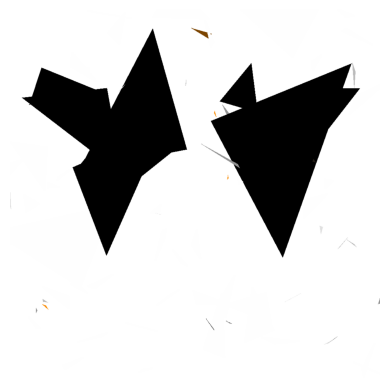

In [16]:


# Get the best individual
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

# Convert the best individual to an image
best_image = best_individual.draw()

# Convert the image to a format suitable for plt.imshow
best_image_array = np.array(best_image)

# Display the image using Matplotlib
plt.imshow(best_image_array)
plt.axis('off')  # Turn off axis labels
plt.show()

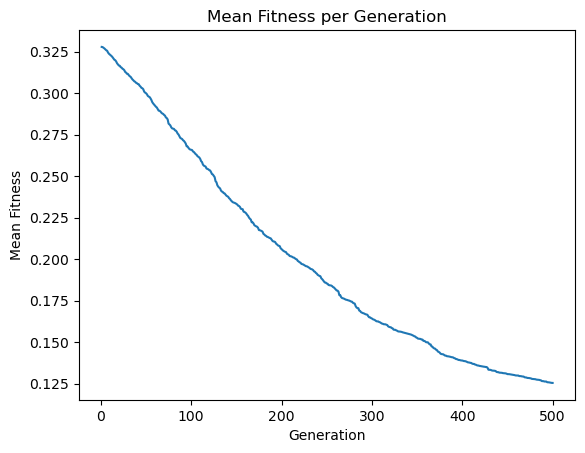

In [17]:
fitness_file = "fitness_values_.txt"

with open(fitness_file, "r") as file:
    fitness_values = [float(line.strip()) for line in file]

num_generations_per_run = 500
num_runs = len(fitness_values) // num_generations_per_run

fitness_values = np.array(fitness_values)
fitness_values = fitness_values.reshape(num_runs, num_generations_per_run)

mean_fitness_per_generation = np.mean(fitness_values, axis=0)

plt.plot(range(1, num_generations_per_run + 1), mean_fitness_per_generation)
plt.xlabel('Generation')
plt.ylabel('Mean Fitness')
plt.title('Mean Fitness per Generation')
plt.show()